In [1]:
!pip install python-intervals

In [2]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import intervals

In [3]:
#from vani.analyzer import Analyzer

In [4]:
# # Initialize analyzer
# cluster_settings = dict(
#     dashboard_port=3446,
#     local_directory="/var/tmp/dask",
#     log_file="digio.worker.log"
# )
# vn = Analyzer(debug=True, cluster_settings=cluster_settings)

# # Analysis configuration
# log_dir = "/p/gpfs1/iopp/recorder_app_logs/genome_pegasus/nodes-32/_parquet"

In [5]:
#analysis = vn.analyze_parquet_logs(log_dir, depth=10, persist_stats=True, stats_file_prefix="cm1_")

In [6]:
#files = vn.ensure_logs_partitioned(log_dir=log_dir)

In [7]:
# def wait_until_workers_alive(filter_group_index: str, n_workers: int = None):
#     # Get current number of workers
#     current_n_workers = len(vn.clients[filter_group_index].scheduler_info()['workers'])
#     expected_n_workers = int(vn.n_workers_per_node if n_workers is None else n_workers)
#     # Wait until enough number of workers alive
#     while vn.clients[filter_group_index].status == 'running' and current_n_workers < expected_n_workers:
#         # Log status
#         vn.logger.debug(
#             format_log(filter_group_index, f"{current_n_workers}/{expected_n_workers} workers running"))
#         # Ensure loop
#         vn.ensure_asyncio_loop()
#         # Try correcting state
#         # noinspection PyProtectedMember
#         vn.clusters[filter_group_index]._correct_state()
#         # Sleep a little
#         sleep(1)
#         # Get current number of workers
#         current_n_workers = len(vn.clients[filter_group_index].scheduler_info()['workers'])
#     # Print result
#     vn.logger.debug(format_log(filter_group_index, "All workers alive"))

In [8]:
import dask
import dask.dataframe as dd
import functools
import glob
import json
import logging
import math
import os
import psutil
import socket
from anytree import PostOrderIter
from concurrent.futures import ThreadPoolExecutor, as_completed
from dask.distributed import Client, LocalCluster, get_task_stream, progress, wait
from distributed.diagnostics.plugin import SchedulerPlugin
from dask_jobqueue import LSFCluster
from time import perf_counter, sleep
from tqdm.auto import tqdm
from typing import Union

In [9]:
# from vani.utils.logger import ElapsedTimeLogger, create_logger, format_log
# filter_group_index='tmid'
# wait_until_workers_alive(filter_group_index, vn.n_workers_per_node / 2)
# #wait_workers = vn.clients[filter_group_index].submit()
# #wait_workers.result()

In [10]:
import dask.dataframe as dd
from dask.distributed import Client
import dask_jobqueue
from dask_jobqueue import LSFCluster

In [11]:
node_memory = 1600 # node memory in GB
n_workers_per_node = 16 # number of worker processes per node
n_threads_per_worker = 1
worker_time = 120 # job time per node for worker
worker_queue = "pdebug" # queue to be used per worker
import socket
host = socket.gethostname()
dashboard_address = '{}:8788'.format(socket.gethostname())
memory = '{}GB'.format(node_memory/n_workers_per_node)
job_extra = ['-nnodes 1', 
             '-G asccasc', 
             '-q {}'.format(worker_queue), 
             '-W {}'.format(worker_time)]
local_directory="/var/tmp/dask/"
cluster = LSFCluster(cores = n_workers_per_node*n_threads_per_worker,processes=n_workers_per_node, memory='{}GB'.format(node_memory), 
                     header_skip=['-n ','-R','-M', '-P', '-W 00:30'], 
                     job_extra = job_extra, 
                     death_timeout=worker_time*60,
                     local_directory =f"{local_directory}",
                     use_stdin=True, 
                     scheduler_options={"port": 0,"host":host, "dashboard_address": ':8788'})
client = Client(cluster, set_as_default=True)

In [12]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.LSFCluster
Dashboard: http://192.168.66.200:8788/status,
Dashboard: http://192.168.66.200:8788/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://192.168.66.200:42965,Workers: 0
Dashboard: http://192.168.66.200:8788/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [13]:
cluster.scale(n_workers_per_node*1)

In [14]:
def draw_graph(future):
    dask_graph = future.__dask_graph__()
    edges = []
    edge_count = {}
    for key, value in dask_graph.dependencies.items():
        vals = list(value)
        destination = key.split("-")[0]
        for val in vals:
            source = val.split("-")[0]
            str_edge = str(source) + "-" + str(destination)
            if str_edge not in edge_count:
                edge_count[str_edge] = 0
            edge_count[str_edge] = edge_count[str_edge] + 1
            edges.append((source, destination))
    #print(edges[:5])
    import networkx as nx
    dag = nx.DiGraph()
    dag.add_edges_from(edges)
    import graphviz
    dot = graphviz.Digraph()
    for node in dag.nodes:
        dot.node(node)
        #print(node)
    for edge_str, count in edge_count.items():
        source, destination  = edge_str.split("-")
        dot.edge(source, destination, label=str(count))
    return dot

In [15]:
delimiter = '-'
def merge(x, y):
    import numpy as np
    return {
        'read': {
            'uniq_ranks': np.union1d(x['read']['uniq_ranks'],y['read']['uniq_ranks']),
            'agg_dur': x['read']['agg_dur'] + y['read']['agg_dur'],
            'total_io_size': x['read']['total_io_size'] + y['read']['total_io_size'],
            'uniq_filenames': np.union1d(x['read']['uniq_filenames'],y['read']['uniq_filenames']),
            'bw_sum': x['read']['bw_sum'] + y['read']['bw_sum'],
            'ops': x['read']['ops'] + y['read']['ops'],
        },
        'write': {
            'uniq_ranks': np.union1d(x['write']['uniq_ranks'],y['write']['uniq_ranks']),
            'agg_dur': x['write']['agg_dur'] + y['write']['agg_dur'],
            'total_io_size': x['write']['total_io_size'] + y['write']['total_io_size'],
            'uniq_filenames': np.union1d(x['write']['uniq_filenames'],y['write']['uniq_filenames']),
            'bw_sum': x['write']['bw_sum'] + y['write']['bw_sum'],
            'ops': x['write']['ops'] + y['write']['ops'],
        },
        'metadata': {
            'uniq_ranks': np.union1d(x['metadata']['uniq_ranks'],y['metadata']['uniq_ranks']),
            'agg_dur': x['metadata']['agg_dur'] + y['metadata']['agg_dur'],
            'uniq_filenames': np.union1d(x['metadata']['uniq_filenames'],y['metadata']['uniq_filenames']),
            'ops': x['metadata']['ops'] + y['metadata']['ops'],
        }
    }

def filter(target_ddf, filter_group_index: str):
    import numpy as np
    #target_ddf = ddf.loc[start:stop]
    # Select dataframes
    #result = wait(target_ddf)
    import intervals
    empty = {
            'uniq_ranks': [],
            'agg_dur': 0.0,
            'total_io_size': 0,
            'uniq_filenames': [],
            'bw_sum': 0.0,
            'ops': 0,
        }
    if target_ddf.empty:
        return {
        'read': empty,
        'write': empty,
        'metadata': empty
    }
    import pandas as pd
    def f(x):
        d = {}
        d['duration'] = x['duration'].sum()
        d['size'] = x['size'].sum()
        d['bandwidth'] = x['bandwidth'].sum()
        d['index'] = x['index'].count()
        d['proc_id'] = x['proc_id'].unique()
        d['file_id'] = x['file_id'].unique()
        return pd.Series(d, index=['duration', 'size', 'bandwidth', 'index', 'proc_id', 'file_id'])
    
    aggregated_values = target_ddf.groupby('io_cat').apply(f)
    
    
#     read_ddf = target_ddf[(target_ddf['io_cat'] == 1)]
#     write_ddf = target_ddf[(target_ddf['io_cat'] == 2)]
#     metadata_ddf = target_ddf[(target_ddf['io_cat'] == 3)]
#     # TODO: on same compute run for all ddf.
#     # Create tasks
#     read_tasks = [
#         read_ddf.index.unique() if filter_group_index == 'proc_id' else read_ddf['proc_id'].unique(),
#         read_ddf['duration'].sum(),
#         read_ddf['size'].sum(),
#         read_ddf.index.unique() if filter_group_index == 'file_id' else read_ddf['file_id'].unique(),
#         read_ddf['bandwidth'].sum(),
#         read_ddf['index'].count(),
#     ]
#     write_tasks = [
#         write_ddf.index.unique() if filter_group_index == 'proc_id' else write_ddf['proc_id'].unique(),
#         write_ddf['duration'].sum(),
#         write_ddf['size'].sum(),
#         write_ddf.index.unique() if filter_group_index == 'file_id' else write_ddf['file_id'].unique(),
#         write_ddf['bandwidth'].sum(),
#         write_ddf['index'].count(),
#     ]
#     metadata_tasks = [
#         metadata_ddf.index.unique() if filter_group_index == 'proc_id' else metadata_ddf['proc_id'].unique(),
#         metadata_ddf['duration'].sum(),
#         metadata_ddf.index.unique() if filter_group_index == 'file_id' else metadata_ddf['file_id'].unique(),
#         metadata_ddf['index'].count(),
#     ]
#     filter_tasks = []
#     filter_tasks.extend(read_tasks)
#     filter_tasks.extend(write_tasks)
#     filter_tasks.extend(metadata_tasks)
#     # Compute all
#     filter_results = dask.compute(*filter_tasks)
    # Clear dataframes
    #del read_ddf
    del target_ddf
    # Arrange results
    #read_start, read_end = 0, len(read_tasks)
    #write_start, write_end = len(read_tasks), len(read_tasks) + len(write_tasks)
    #metadata_start, metadata_end = len(read_tasks) + len(write_tasks), 0
    index_values = aggregated_values.index.unique()
    read_values = empty
    write_values = empty
    metadata_values = empty
    if 1 in index_values:
        read_values = {
            'uniq_ranks': aggregated_values.loc[1]['proc_id'],
            'agg_dur': aggregated_values.loc[1]['duration'],
            'total_io_size': aggregated_values.loc[1]['size'],
            'uniq_filenames': aggregated_values.loc[1]['file_id'],
            'bw_sum': aggregated_values.loc[1]['bandwidth'],
            'ops': aggregated_values.loc[1]['index'],
        }
    if 2 in index_values:
        write_values = {
            'uniq_ranks': aggregated_values.loc[2]['proc_id'],
            'agg_dur': aggregated_values.loc[2]['duration'],
            'total_io_size': aggregated_values.loc[2]['size'],
            'uniq_filenames': aggregated_values.loc[2]['file_id'],
            'bw_sum': aggregated_values.loc[2]['bandwidth'],
            'ops': aggregated_values.loc[2]['index'],
        }
    if 3 in index_values:
        metadata_values = {
            'uniq_ranks': aggregated_values.loc[3]['proc_id'],
            'agg_dur': aggregated_values.loc[3]['duration'],
            'total_io_size': aggregated_values.loc[3]['size'],
            'uniq_filenames': aggregated_values.loc[3]['file_id'],
            'bw_sum': aggregated_values.loc[3]['bandwidth'],
            'ops': aggregated_values.loc[3]['index'],
        }
    filter_result = {
        'read': read_values,
        'write': write_values,
        'metadata': metadata_values
    }
    # Return results
    return filter_result
def cal_len(x):
    return {
        'read': {
            'uniq_ranks': len(x['read']['uniq_ranks']),
            'agg_dur': x['read']['agg_dur'],
            'total_io_size': x['read']['total_io_size'],
            'uniq_filenames': len(x['read']['uniq_filenames']),
            'bw_sum': x['read']['bw_sum'],
            'ops': x['read']['ops'],
        },
        'write': {
            'uniq_ranks': len(x['write']['uniq_ranks']),
            'agg_dur': x['write']['agg_dur'],
            'total_io_size': x['write']['total_io_size'],
            'uniq_filenames': len(x['write']['uniq_filenames']),
            'bw_sum': x['write']['bw_sum'],
            'ops': x['write']['ops'],
        },
        'metadata': {
            'uniq_ranks': len(x['metadata']['uniq_ranks']),
            'agg_dur': x['metadata']['agg_dur'],
            'uniq_filenames': len(x['metadata']['uniq_filenames']),
            'ops': x['metadata']['ops']
        }
    }

from dask.graph_manipulation import bind
def compute_min_max(log_dir: str, filter_group_index: str, depth):
    with open(f"{log_dir}/global.json") as file:
        global_metrics = json.load(file)
        min_val, max_val = global_metrics[filter_group_index][0], global_metrics[filter_group_index][1]
        next_tasks = 2 ** depth
        interval = math.ceil((max_val - min_val) * 1.0 / next_tasks)
        time_range = range(min_val, max_val, interval)
        return interval, time_range
def compute_metrics(ddf, filter_group_index: str, interval, time_range, wait_persist_delayed):
    iterations = list(range(0, MAX_DEPTH + 1))
    iterations.reverse()
    all_tasks = [0] * (MAX_DEPTH + 1)
    for i in iterations:
        tasks = []
        if i == MAX_DEPTH:
            for start in time_range:
                stop = start + interval - 1
                
                target_ddf = delayed_func(lambda ddf, start, stop, ignore: ddf.loc[start:stop].reset_index().compute(), f"splice_ddf{delimiter}{start}_{stop}", [ddf, start, stop,wait_persist_delayed])
                tasks.append(delayed_func(filter, f"filter{delimiter}{start}_{stop}", [target_ddf, filter_group_index]))
        else:
            next_tasks = len(all_tasks[i + 1])
            if next_tasks % 2 == 1:
                next_tasks = next_tasks - 1
            for t in range(0, next_tasks, 2):
                tasks.append(delayed_func(merge, f"merge{delimiter}{i}_{t}_{t+1}", [all_tasks[i + 1][t], all_tasks[i + 1][t + 1]]))
            next_tasks = len(all_tasks[i + 1])
            if next_tasks % 2 == 1:
                tasks.append(all_tasks[i + 1][next_tasks - 1])
            # TODO why are we calling len on everything?
            for t, next_tasks in enumerate(all_tasks[i + 1]):
                all_tasks[i + 1][t] = delayed_func(cal_len, f"cal_len{delimiter}{i+1}_{t}", [next_tasks])
        all_tasks[i] = tasks
#     if len(all_tasks[0]) == 2:
#         all_tasks[0] = [delayed_func(merge, f"merge{delimiter}{0}_{0}_{1}", [all_tasks[0][0], all_tasks[0][1]])]
#         all_tasks[0] = [delayed_func(cal_len,f"cal_len{delimiter}0_{t}",all_tasks[0][0])]
    for t, next_tasks in enumerate(all_tasks[0]):
        all_tasks[0][t] = delayed_func(cal_len,f"cal_len{delimiter}0_{t}",[next_tasks])
    #print(all_tasks)
    return all_tasks

In [16]:
import dask
def delayed_func(func, name, args, nout=1):
    if name:
        func.__name__ = name
    obj = dask.delayed(func, nout=nout)(*args, dask_key_name=name)
    return obj
def wait_delayed(ddf):
    result = wait(ddf)
    return 1
def dummy(x):
    return x
MAX_DEPTH = 10
log_dir = "/p/gpfs1/iopp/recorder_app_logs/cm1/nodes-32/workflow-4/_parquet"
filter_group_index='tmid'
delayed_list =[]
interval, time_range = compute_min_max(log_dir, filter_group_index, MAX_DEPTH)
read_delayed = delayed_func(lambda log_dir: dd.read_parquet(f"{log_dir}/*.parquet", index=False), f"read_parquet_{filter_group_index}", [log_dir])
delayed_list.append(read_delayed)
index_delayed = delayed_func(lambda filter_group_index, ddf: ddf.set_index([filter_group_index]), f"index_delayed_{filter_group_index}", [filter_group_index, read_delayed])
delayed_list.append(index_delayed)
persist_delayed = delayed_func(lambda ddf: ddf.persist(), f"persist_{filter_group_index}" , [index_delayed])
delayed_list.append(persist_delayed)
#unique_processes = delayed_func(lambda ddf: ddf.groupby(ddf.index)['hostname','rank','thread_id'].min().compute(), f"groupby_{filter_group_index}" , [index_delayed])
#delayed_list.append(unique_processes)
wait_persist_delayed = delayed_func(wait_delayed, f"wait_delayed_{filter_group_index}", [persist_delayed])
delayed_list.append(wait_persist_delayed)
compute_metrics_delayed = compute_metrics(persist_delayed, filter_group_index, interval, time_range, wait_persist_delayed)
compute_metrics_delayed.reverse()
for index, compute_metric_item in enumerate(compute_metrics_delayed):
    delayed_list.append(dask.delayed(dummy)(compute_metric_item,dask_key_name=f"depth_{len(compute_metrics_delayed) - index - 1}_{filter_group_index}"))
print(len(delayed_list))
#compute_metrics_delayed = delayed_func(compute_metrics, "compute_metrics", [wait_persist_delayed, filter_group_index, compute_min_max_delayed])
total = dask.delayed(delayed_list)(dask_key_name=f"{filter_group_index}_all")

15


In [17]:
interval

6526422

In [18]:
time_range

range(0, 6683055996, 6526422)

In [19]:
dot = draw_graph(total)

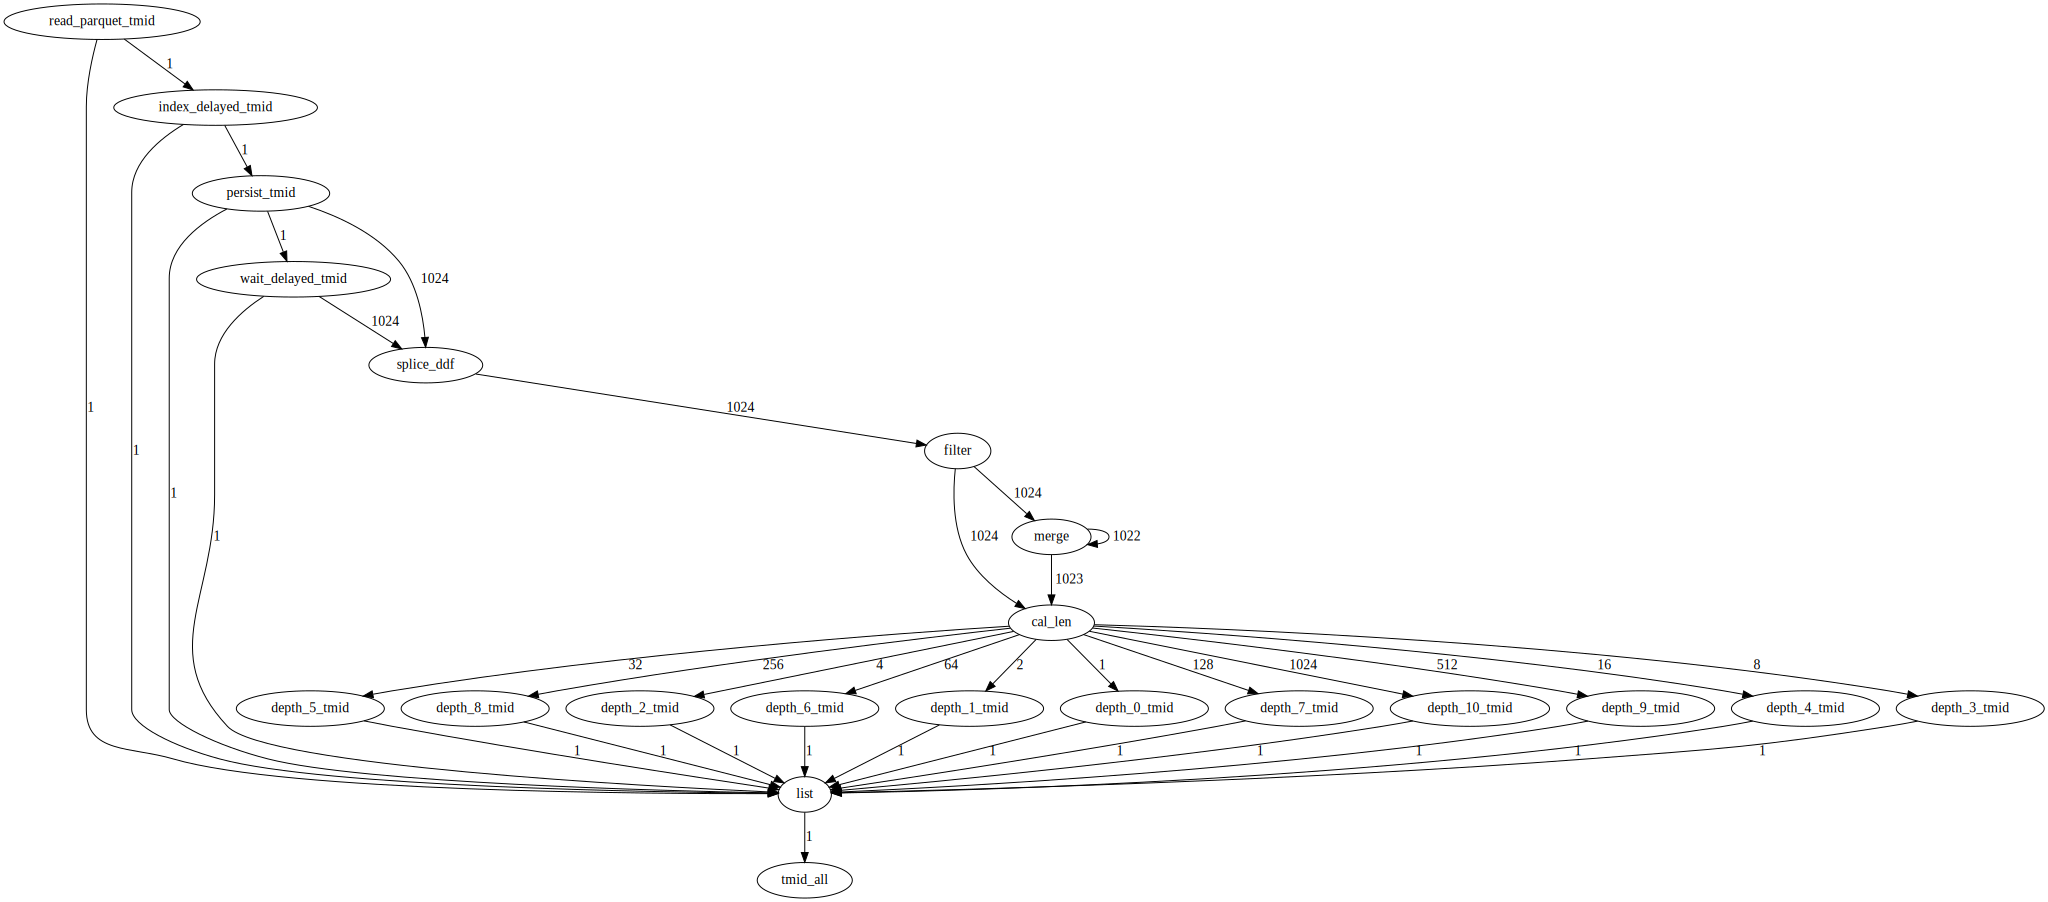

In [20]:
dot

In [21]:
%%time
# Progress bar on a single-machine scheduler
from dask.distributed import performance_report
from dask.distributed import as_completed
futures = client.compute(delayed_list, sync=False)

CPU times: user 2.74 s, sys: 261 ms, total: 3 s
Wall time: 2.98 s


In [22]:
delayed_list

[Delayed('read_parquet_tmid'),
 Delayed('index_delayed_tmid'),
 Delayed('persist_tmid'),
 Delayed('wait_delayed_tmid'),
 Delayed('depth_10_tmid'),
 Delayed('depth_9_tmid'),
 Delayed('depth_8_tmid'),
 Delayed('depth_7_tmid'),
 Delayed('depth_6_tmid'),
 Delayed('depth_5_tmid'),
 Delayed('depth_4_tmid'),
 Delayed('depth_3_tmid'),
 Delayed('depth_2_tmid'),
 Delayed('depth_1_tmid'),
 Delayed('depth_0_tmid')]

In [23]:
%%time
import time
start_time = time.time()
for future in as_completed(futures):
    end_time = time.time() - start_time
    print(f"{future.key} {future.status} {end_time/60}")

read_parquet_tmid finished 0.19784373839696248
index_delayed_tmid finished 0.23212414979934692
persist_tmid finished 0.2324788451194763
wait_delayed_tmid finished 0.25429566303888956
depth_10_tmid finished 0.4038934389750163
depth_9_tmid finished 0.4039950927098592
depth_8_tmid finished 0.4111577351888021
depth_7_tmid finished 0.4132782260576884
depth_6_tmid finished 0.4171972433725993
depth_5_tmid finished 0.4178553342819214
depth_4_tmid finished 0.41897121667861936
depth_3_tmid finished 0.41925800244013467
depth_2_tmid finished 0.4195503195126851
depth_1_tmid finished 0.4197252114613851
depth_0_tmid finished 0.4198188781738281
CPU times: user 8.82 s, sys: 269 ms, total: 9.09 s
Wall time: 25.2 s


In [36]:
metrics = []
for i in futures[4:]:
    metrics.append(i.result())

In [37]:
metrics.reverse()

In [42]:
len(metrics[10])

1024

In [45]:
import numpy as np
class NpEncoder(json.JSONEncoder):
    def default(self, obj):
        if isinstance(obj, np.integer):
            return int(obj)
        if isinstance(obj, np.floating):
            return float(obj)
        if isinstance(obj, np.ndarray):
            return obj.tolist()
        return super(NpEncoder, self).default(obj)
with open("cm1_metrics.json", "w") as f:
    json.dump(metrics, f, cls=NpEncoder)

In [ ]:
%%time
# Progress bar on a single-machine scheduler
from dask.diagnostics import ProgressBar
futures_2 = client.compute(delayed_list[5:], sync=False)

In [ ]:
futures_2

In [ ]:
futures_2[-1:][0].result()

In [ ]:
for future in futures:
    if future.status not in ["finished"]:
        print(f"canceling {future.key}")
        future.cancel()

In [ ]:
for future in futures:
    if "depth" in future.key:
        print(f"canceling {future.key}")
        future.cancel()

In [ ]:
for future in futures:
    future.cancel()

In [ ]:
for future in futures:
    if future.status in ["error"]:
        print(f"printing exception {future.key}")
        print(future.exception())

In [ ]:
for future in futures:
    if future.status  in ["error"]:
        print(f"canceling {future.key}")
        future.cancel()

In [ ]:
if futures[4].done():
    metrics = futures[4].result()
else:
    print("future is pending")

In [ ]:
metrics

In [ ]:
import numpy as np
PARTITION_FOLDER = "partitioned_hari"
def indexed_ddf(log_dir: str, filter_group_index: str):
    ddf = dd.read_parquet(f"{log_dir}/*.parquet", index=False)
    #ddf[filter_group_index] = ddf[filter_group_index].astype(np.int64)
    ddf = ddf.set_index([filter_group_index])
    ddf = ddf.persist()
    #result = wait(ddf)
    return ddf

def compute_metrics(ddf, filter_group_index: str, interval):
    min_val, max_val = interval
    

    depth = 10
    next_tasks = 2 ** depth
    interval = math.ceil((max_val - min_val) * 1.0 / next_tasks)
    iterations = list(range(0, depth + 1))
    iterations.reverse()
    all_tasks = [0] * (depth + 1)
    time_range = range(min_val, max_val, interval)
    for i in iterations:
        tasks = []
        if i == depth:
            for start in time_range:
                stop = start + interval - 1
                target_ddf = ddf.loc[start:stop]
                tasks.append(dask.delayed(filter)(target_ddf, filter_group_index))
        else:
            next_tasks = len(all_tasks[i + 1])
            if next_tasks % 2 == 1:
                next_tasks = next_tasks - 1
            for t in range(0, next_tasks, 2):
                tasks.append(dask.delayed(merge)(all_tasks[i + 1][t], all_tasks[i + 1][t + 1]))
            next_tasks = len(all_tasks[i + 1])
            if next_tasks % 2 == 1:
                tasks.append(all_tasks[i + 1][next_tasks - 1])
            # TODO why are we calling len on everything?
            for t, next_tasks in enumerate(all_tasks[i + 1]):
                all_tasks[i + 1][t] = dask.delayed(cal_len)(next_tasks)
        all_tasks[i] = tasks
    for t, next_tasks in enumerate(all_tasks[0]):
        all_tasks[0][t] = dask.delayed(cal_len)(next_tasks)
    metrics = dask.compute(all_tasks)    
    #result = wait(metrics_futures)
    #metrics = client.gather(metrics_futures)
    return metrics

In [ ]:
# json_index = 'tmid'
# futures = []
# args = [log_dir, json_index, filter_group_index]
# interval_ft = vn.clients[filter_group_index].submit(compute_min_max, *args, key=f'{filter_group_index}_compute_min_max')
# futures.append(interval_ft)
# args = [log_dir, filter_group_index]
# indexed_ft = vn.clients[filter_group_index].submit(indexed_ddf, *args, key=f'{filter_group_index}_indexed_ddf')
# futures.append(indexed_ft)
# args = [indexed_ft, filter_group_index, interval_ft]
# metrics_ft = vn.clients[filter_group_index].submit(compute_metrics, *args, key=f'{filter_group_index}_compute_metrics')
# futures.append(metrics_ft)

In [ ]:
# from dask.distributed import as_completed
# from tqdm.auto import tqdm
# metrics_map = {}
# for future in tqdm(as_completed(futures)):
#     if "compute_metrics" in future.key:
#         metrics_map[future.key] = future.result(timeout=(2*60*60))
#     print(f'{future.key} completed')

In [ ]:
# metrics_map

In [ ]:
json_keys = dict(tmid='tmid', proc_id='proc_id', file_id='file_id')
futures = []
for filter_group_index in vn.filter_group_indices:
    json_index = json_keys[filter_group_index]
    args = [log_dir, json_index, filter_group_index]
    interval_ft = vn.clients[filter_group_index].submit(compute_min_max, *args, key=f'{filter_group_index}_compute_min_max')
    futures.append(interval_ft)
    args = [log_dir, filter_group_index]
    indexed_ft = vn.clients[filter_group_index].submit(indexed_ddf, *args, key=f'{filter_group_index}_indexed_ddf')
    futures.append(indexed_ft)
    args = [indexed_ft, filter_group_index, interval_ft]
    metrics_ft = vn.clients[filter_group_index].submit(compute_metrics, *args, key=f'{filter_group_index}_compute_metrics')
    futures.append(metrics_ft)


In [ ]:
%%time
from dask.distributed import as_completed
from tqdm.auto import tqdm
metrics_map = {}
for future in tqdm(as_completed(futures)):
    if "compute_metrics" in future.key:
        metrics_map[future.key] = future.result(timeout=(2*60*60))
    print(f'{future.key} completed')

In [ ]:
# min_val, max_val = metrics_map["tmid_compute_min_max"]
# depth = 10
# next_tasks = 2 ** depth
# interval = math.ceil((max_val - min_val) * 1.0 / next_tasks)
# time_range = range(min_val, max_val, interval)
# for start in time_range:
#     print(start, start + interval - 1)

In [ ]:
def merge_result(x, y):
    return {
        'read': {
            'uniq_ranks': x['read']['uniq_ranks'] + y['read']['uniq_ranks'],
            'agg_dur': x['read']['agg_dur'] + y['read']['agg_dur'],
            'total_io_size': x['read']['total_io_size'] + y['read']['total_io_size'],
            'uniq_filenames': x['read']['uniq_filenames'] + y['read']['uniq_filenames'],
            'bw_sum': x['read']['bw_sum'] + y['read']['bw_sum'],
            'ops': x['read']['ops'] + y['read']['ops'],
        },
        'write': {
            'uniq_ranks': x['write']['uniq_ranks'] + y['write']['uniq_ranks'],
            'agg_dur': x['write']['agg_dur'] + y['write']['agg_dur'],
            'total_io_size': x['write']['total_io_size'] + y['write']['total_io_size'],
            'uniq_filenames': x['write']['uniq_filenames'] + y['write']['uniq_filenames'],
            'bw_sum': x['write']['bw_sum'] + y['write']['bw_sum'],
            'ops': x['write']['ops'] + y['write']['ops'],
        },
        'metadata': {
            'uniq_ranks': x['metadata']['uniq_ranks'] + y['metadata']['uniq_ranks'],
            'agg_dur': x['metadata']['agg_dur'] + y['metadata']['agg_dur'],
            'uniq_filenames': x['metadata']['uniq_filenames'] + y['metadata']['uniq_filenames'],
            'ops': x['metadata']['ops'] + y['metadata']['ops'],
        }
    }

In [ ]:
metrics_map['tmid_compute_metrics'][0][0]

In [ ]:
merge_result(metrics_map['proc_id_compute_metrics'][0][0][0],metrics_map['proc_id_compute_metrics'][0][0][1])

In [ ]:
metrics_map['file_id_compute_metrics'][0][0]

In [ ]:
metrics_map

In [ ]:
metrics_map['file_id_indexed_ddf'].compute()

In [ ]:
metrics_map['tmid_compute_metrics'][0][10]

In [ ]:
metrics_map['proc_id_compute_metrics'][0][0]

In [ ]:
metrics_map['file_id_compute_metrics'][0][0][0]

In [ ]:
import dask.dataframe as dd
from dask.distributed import Client, LocalCluster
local_client = Client(LocalCluster(n_workers=16))

In [ ]:
local_client

In [ ]:
log_dir = "/p/gpfs1/iopp/recorder_app_logs/genome_pegasus/nodes-32/_parquet"
ddf = dd.read_parquet(f"{log_dir}/*.parquet", index=False)

In [ ]:
values = dd.compute(ddf['tmid'].min(), ddf['tmid'].max(), ddf['file_id'].min(), ddf['file_id'].max(), ddf['proc_id'].min(), ddf['proc_id'].max())

In [ ]:
values

In [ ]:
min_val, max_val = -9223371986035283781, 9223369538921024184

next_tasks = 2 ** 10
interval = math.ceil((max_val - min_val) * 1.0 / next_tasks)
time_range = range(min_val, max_val, interval)
print(time_range)
for start in time_range:
    print(start, start + interval -1)

In [ ]:
!pip install python-intervals